<a href="https://colab.research.google.com/github/LxYuan0420/eat_tensorflow2_in_30_days/blob/master/notebooks/3_2_Mid_level_API_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3-2 Mid-level API: Demonstration**

The examples below use mid-level APIs in TensorFlow to implement a linear regression model and a DNN binary classification model.

Mid-level API includes model layers, loss functions, optimizers, data pipelines, feature columns, etc.

In [1]:
import tensorflow as tf

# Time stamp
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)


**1. Linear Regression Model**

(a) Data Preparation

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

# Number of samples
n = 400

X = tf.random.uniform([n,2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [3.0]])
b0 = tf.constant([2.0])
noise = tf.random.normal([n,1], stddev=2.0)

Y = X@w0 + b0 + noise 

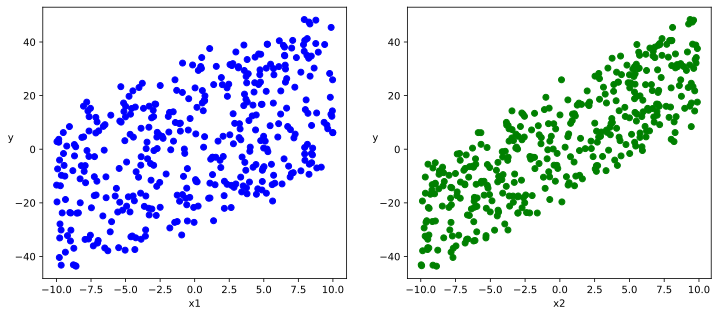

In [3]:
# Data Visualization
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


In [4]:
ds = tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(buffer_size=100).batch(10).prefetch(tf.data.experimental.AUTOTUNE)

**(b) Model Definition**

In [5]:
model = tf.keras.layers.Dense(units=1)
model.build(input_shape=(2,))

model.loss_func = tf.keras.losses.mean_squared_error
model.optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

**(c) Model Training**

In [7]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))

    grads = tape.gradient(loss, model.trainable_variables)

    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss

features, labels = next(ds.as_numpy_iterator())
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=137.04951>

In [9]:
def train_model(model, epochs):
    for epoch in tf.range(epochs+1):
        loss = tf.constant(0.0)

        for features, labels in ds:
            loss = train_step(model, features, labels)

        if epoch%50 == 0:
            tf.print(f"epoch: {epoch}  loss: {loss}")
            tf.print(f"w: {model.variables[0].numpy()}")
            tf.print(f"b: {model.variables[1].numpy()}")


train_model(model, 200)

epoch: 0  loss: 3.254232406616211
w: [[2.0021694]
 [2.9910288]]
b: [2.0819378]
epoch: 50  loss: 1.9519157409667969
w: [[1.9929662]
 [2.9969535]]
b: [2.081298]
epoch: 100  loss: 5.6065497398376465
w: [[1.997941 ]
 [2.9968452]]
b: [2.0819802]
epoch: 150  loss: 4.309106349945068
w: [[2.004852 ]
 [3.0068355]]
b: [2.0816379]
epoch: 200  loss: 0.5121995806694031
w: [[1.9958283]
 [2.9903135]]
b: [2.0822413]


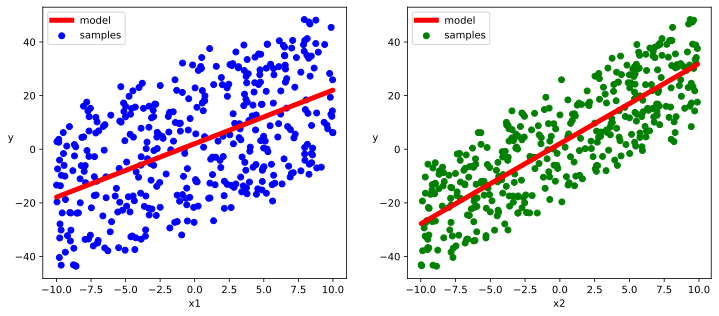

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

---

**2. DNN Binary Classification Model**

**(a) Data Preparation**

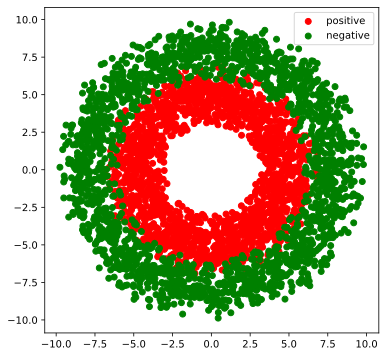

In [11]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Number of the positive/negative samples
n_positive,n_negative = 2000,2000

# Generating the positive samples with a distribution on a smaller ring
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

# Generating the negative samples with a distribution on a larger ring
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

# Assembling all samples
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


# Visualizing the data
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [12]:
ds = tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(buffer_size=100).batch(100).prefetch(tf.data.experimental.AUTOTUNE)

**(b) Model Definition**

In [20]:
class DNNModel(tf.Module):
    def __init__(self, name=None):
        self.dense1 = tf.keras.layers.Dense(4, activation='relu')
        self.dense2 = tf.keras.layers.Dense(8, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid')
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
    def __call__(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)

        return y



In [21]:
model = DNNModel()
model.loss_func = tf.keras.losses.binary_crossentropy
model.metric_func = tf.keras.metrics.binary_accuracy
model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [23]:
features, labels = next(ds.as_numpy_iterator())

predictions = model(features)
loss = model.loss_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))
metrics = model.metric_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))

tf.print(f"int loss: {loss}")
tf.print(f"int metric: {metrics}")

int loss: 0.2129269391298294
int metric: 0.9200000166893005


**(c) Model Training**

In [24]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))

    grads = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    metrics = model.metric_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))

    return loss, metrics

features, labels = next(ds.as_numpy_iterator())
train_step(model, features, labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.22416212>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.93>)

In [32]:
@tf.function
def train_model(model, epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0), tf.constant(0.0)
        for features, labels in ds:
            #loss, metric = train_step(model, features, labels)
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)
train_model(model, 60)

================================================================================00:21:54
epoch = 10 loss =  0.125208363 accuracy =  0.96
================================================================================00:21:56
epoch = 20 loss =  0.0974098593 accuracy =  0.97
================================================================================00:21:57
epoch = 30 loss =  0.13265349 accuracy =  0.96
================================================================================00:21:59
epoch = 40 loss =  0.0925545394 accuracy =  0.97
================================================================================00:22:00
epoch = 50 loss =  0.102733307 accuracy =  0.98
================================================================================00:22:02
epoch = 60 loss =  0.0629114509 accuracy =  0.99


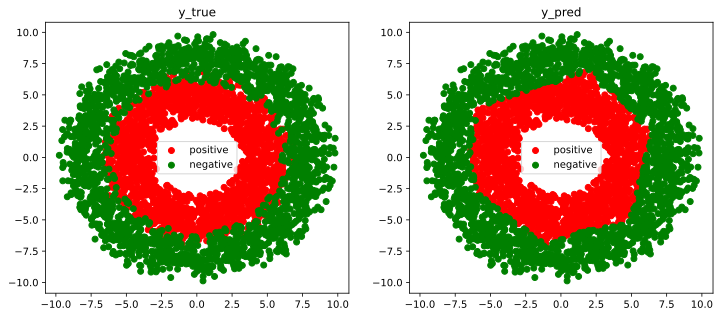

In [33]:
# Visualizing the results
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");